# Comparison of the 2-fold method and our extension

This notebook provides simulation experiments that demonstrate how the 2-fold method can have a very considerable false-positive-rate. We calculate the false-positive-rate for a wide range of scenarios. We demonstrate two things:
1. In the edge cases both methods agree. With edge cases we mean scenarios where we have a large number of subjects, a low variance, or a very poor model. This is unsurprising since our method is an extension of the 2-fold method.
2. In cases where there is simply not enough information to make a decision, our method will refrain from doing so, contrary to the 2-fold method.

### The necessary code, the experiments start below

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy

In [2]:
def geomean(x):
    """Calculate the geometric mean"""
    return np.exp(np.mean(np.log(x)))

In [3]:
def get_acceptance_rate(*, true_ratio, CV, n_subjects, n_predictions=10000, n_simulations=10000):
    """
    Get the acceptance rate when using the 2-fold method.

    Arguments:
        true_ratio: The true geometric mean ratio (e^muhat / e^mu).
        CV: The geometric coefficient of variation of the subjects.
        n_subjects: The number of subjects
        n_simulations: The number of simulations that is used to calculate the acceptance rate

    Return:
        acceptance_rate: The simulated acceptance rate.
    """
    accepted = 0
    true_gmean = 300
    simulated_gmean = true_ratio * true_gmean
    std_dev = np.sqrt(np.log(CV**2 + 1))
    ratios = []
    for i in range(n_simulations):
        observed_values = np.exp(np.random.normal(loc=np.log(true_gmean), scale=std_dev, size=n_subjects))
        predicted_values = np.exp(np.random.normal(loc=np.log(simulated_gmean), scale=std_dev, size=n_predictions))
        ratio =  geomean(predicted_values) / geomean(observed_values)
        ratios.append(ratio)
        if  0.5 <= ratio <= 2:
            accepted += 1
    acceptance_rate = accepted / n_simulations
    return acceptance_rate

In [4]:
def CI_method(GM_observed, GM_predicted, GCV_observed, GCV_predicted, N_observed, N_predicted=10000, alpha=0.1):
    """
    Calculate CI using the GLM approach and considering variance of predictions.

    This function calculates a CI of the difference in means on logscale and
    then transform this back to the original scale. A 2-sided unpaired
    t-test assuming unequal variances is used.

    Arguments:
        GM_observed: Observed geometric mean
        GM_predicted: Predicted geometric mean
        GCV_observed: Observed geometric coefficient of variation
        GCV_predicted: Predicted geometric coefficient of variation
        N_observed: Number of observed subjects
        N_predicted: Number of predicted subjects
        alpha: Confidence level. The default value of 0.1 corresponds to 90% CI.

    Returns:
      The result of the test (reject (0), accept (1), refrain (2))
    """
    average_observed = np.log(GM_observed)
    average_predicted = np.log(GM_predicted)
    var_observed = np.log(GCV_observed**2 + 1)
    var_predicted = np.log(GCV_predicted**2 + 1)
    var_total = var_observed / N_observed + var_predicted / N_predicted
    df = (var_total)**2 \
     / ((var_observed / N_observed)**2 / (N_observed - 1) + (var_predicted / N_predicted)**2 / (N_predicted - 1))
    t = scipy.stats.t(df).ppf(1-alpha/2)
    loglowerbound = average_predicted - average_observed - t * np.sqrt(var_total)
    logupperbound = average_predicted - average_observed + t * np.sqrt(var_total)
    CI = [np.exp(loglowerbound), np.exp(logupperbound)]
    if CI[1] < 0.5:
        return 0  # Reject
    if CI[0] < 0.5 and CI[1] > 0.5:
        return 2  # Refrain
    if CI[0] > 0.5 and CI[1] < 2:
        return 1  # Accept
    if CI[0] < 2 and CI[1] > 2:
        return 2  # Refrain
    if CI[0] > 2:
        return 0  # Reject

In [5]:
def simulate_CI_method(*, true_ratio, CV, n_subjects, n_predictions=10000, n_simulations=10000):
    """Compute the results of a large number of simulated subjects using the CI method."""
    results = np.zeros(n_simulations)
    true_gmean = 300  # Results are the same for any true_gmean since we work with the coefficient of variation.
    simulated_gmean = true_ratio * true_gmean
    std_dev = np.sqrt(np.log(CV**2 + 1))
    for i in range(n_simulations):
        observed_values = np.exp(np.random.normal(loc=np.log(true_gmean), scale=std_dev, size=n_subjects))
        predicted_values = np.exp(np.random.normal(loc=np.log(simulated_gmean), scale=std_dev, size=n_predictions))
        observed_geometric_mean = geomean(observed_values)
        predicted_geometric_mean = geomean(predicted_values)
        GCV_observed = np.sqrt(np.exp(np.var(np.log(observed_values))) - 1)
        GCV_predicted = np.sqrt(np.exp(np.var(np.log(predicted_values))) - 1)
        results[i] = CI_method(GM_observed=observed_geometric_mean, GM_predicted=predicted_geometric_mean,
                               GCV_observed=GCV_observed, GCV_predicted=GCV_predicted,
                               N_observed=n_subjects, N_predicted=n_predictions)
    return results

## Problems with the 2-fold method

The 2-fold method can easily result in a very high false positive rate when we use a small number of subjects. The actual false-positive-rate depends on the variance of the subjects and on the quality of the model. If the true GMR ($e^{\hat{\mu}} / e^{\mu}$) is slightly below 0.5 or above 2, the false-positive-rate will be higher.

We first consider a setting where the true GMR is 0.45 and we have five subjects with a CV of 0.8. We simulate 10.000 sets of 5 patients and calculate how often we would have accepted the model even though we should have rejected it.

In [9]:
accepted = 0
actual_ratio = 0.45  # Actual geometric mean ratio.
true_gmean = 300 # Results only depend on CV, any value for true_gmean gives the same results.
simulated_gmean = actual_ratio * true_gmean
CV = 0.8
std_dev = np.sqrt(np.log(CV**2 + 1))
ratios = []
n_simulations = 10000
n_subjects = 5
for i in range(n_simulations):
    observed_values = np.exp(np.random.normal(loc=np.log(true_gmean), scale=std_dev, size=n_subjects))
    predicted_values = np.exp(np.random.normal(loc=np.log(simulated_gmean), scale=std_dev, size=10000))
    ratio =  geomean(predicted_values) / geomean(observed_values)
    ratios.append(ratio)
    if  0.5 <= ratio <= 2:
        accepted += 1
FPR = accepted / n_simulations
print(f'FPR = {FPR}')

FPR = 0.3654


The histogram below illustrates what is going on. The observed GMR is a random variable since it depends on the random observations. This can lead us to have an acceptable GMR by chance.

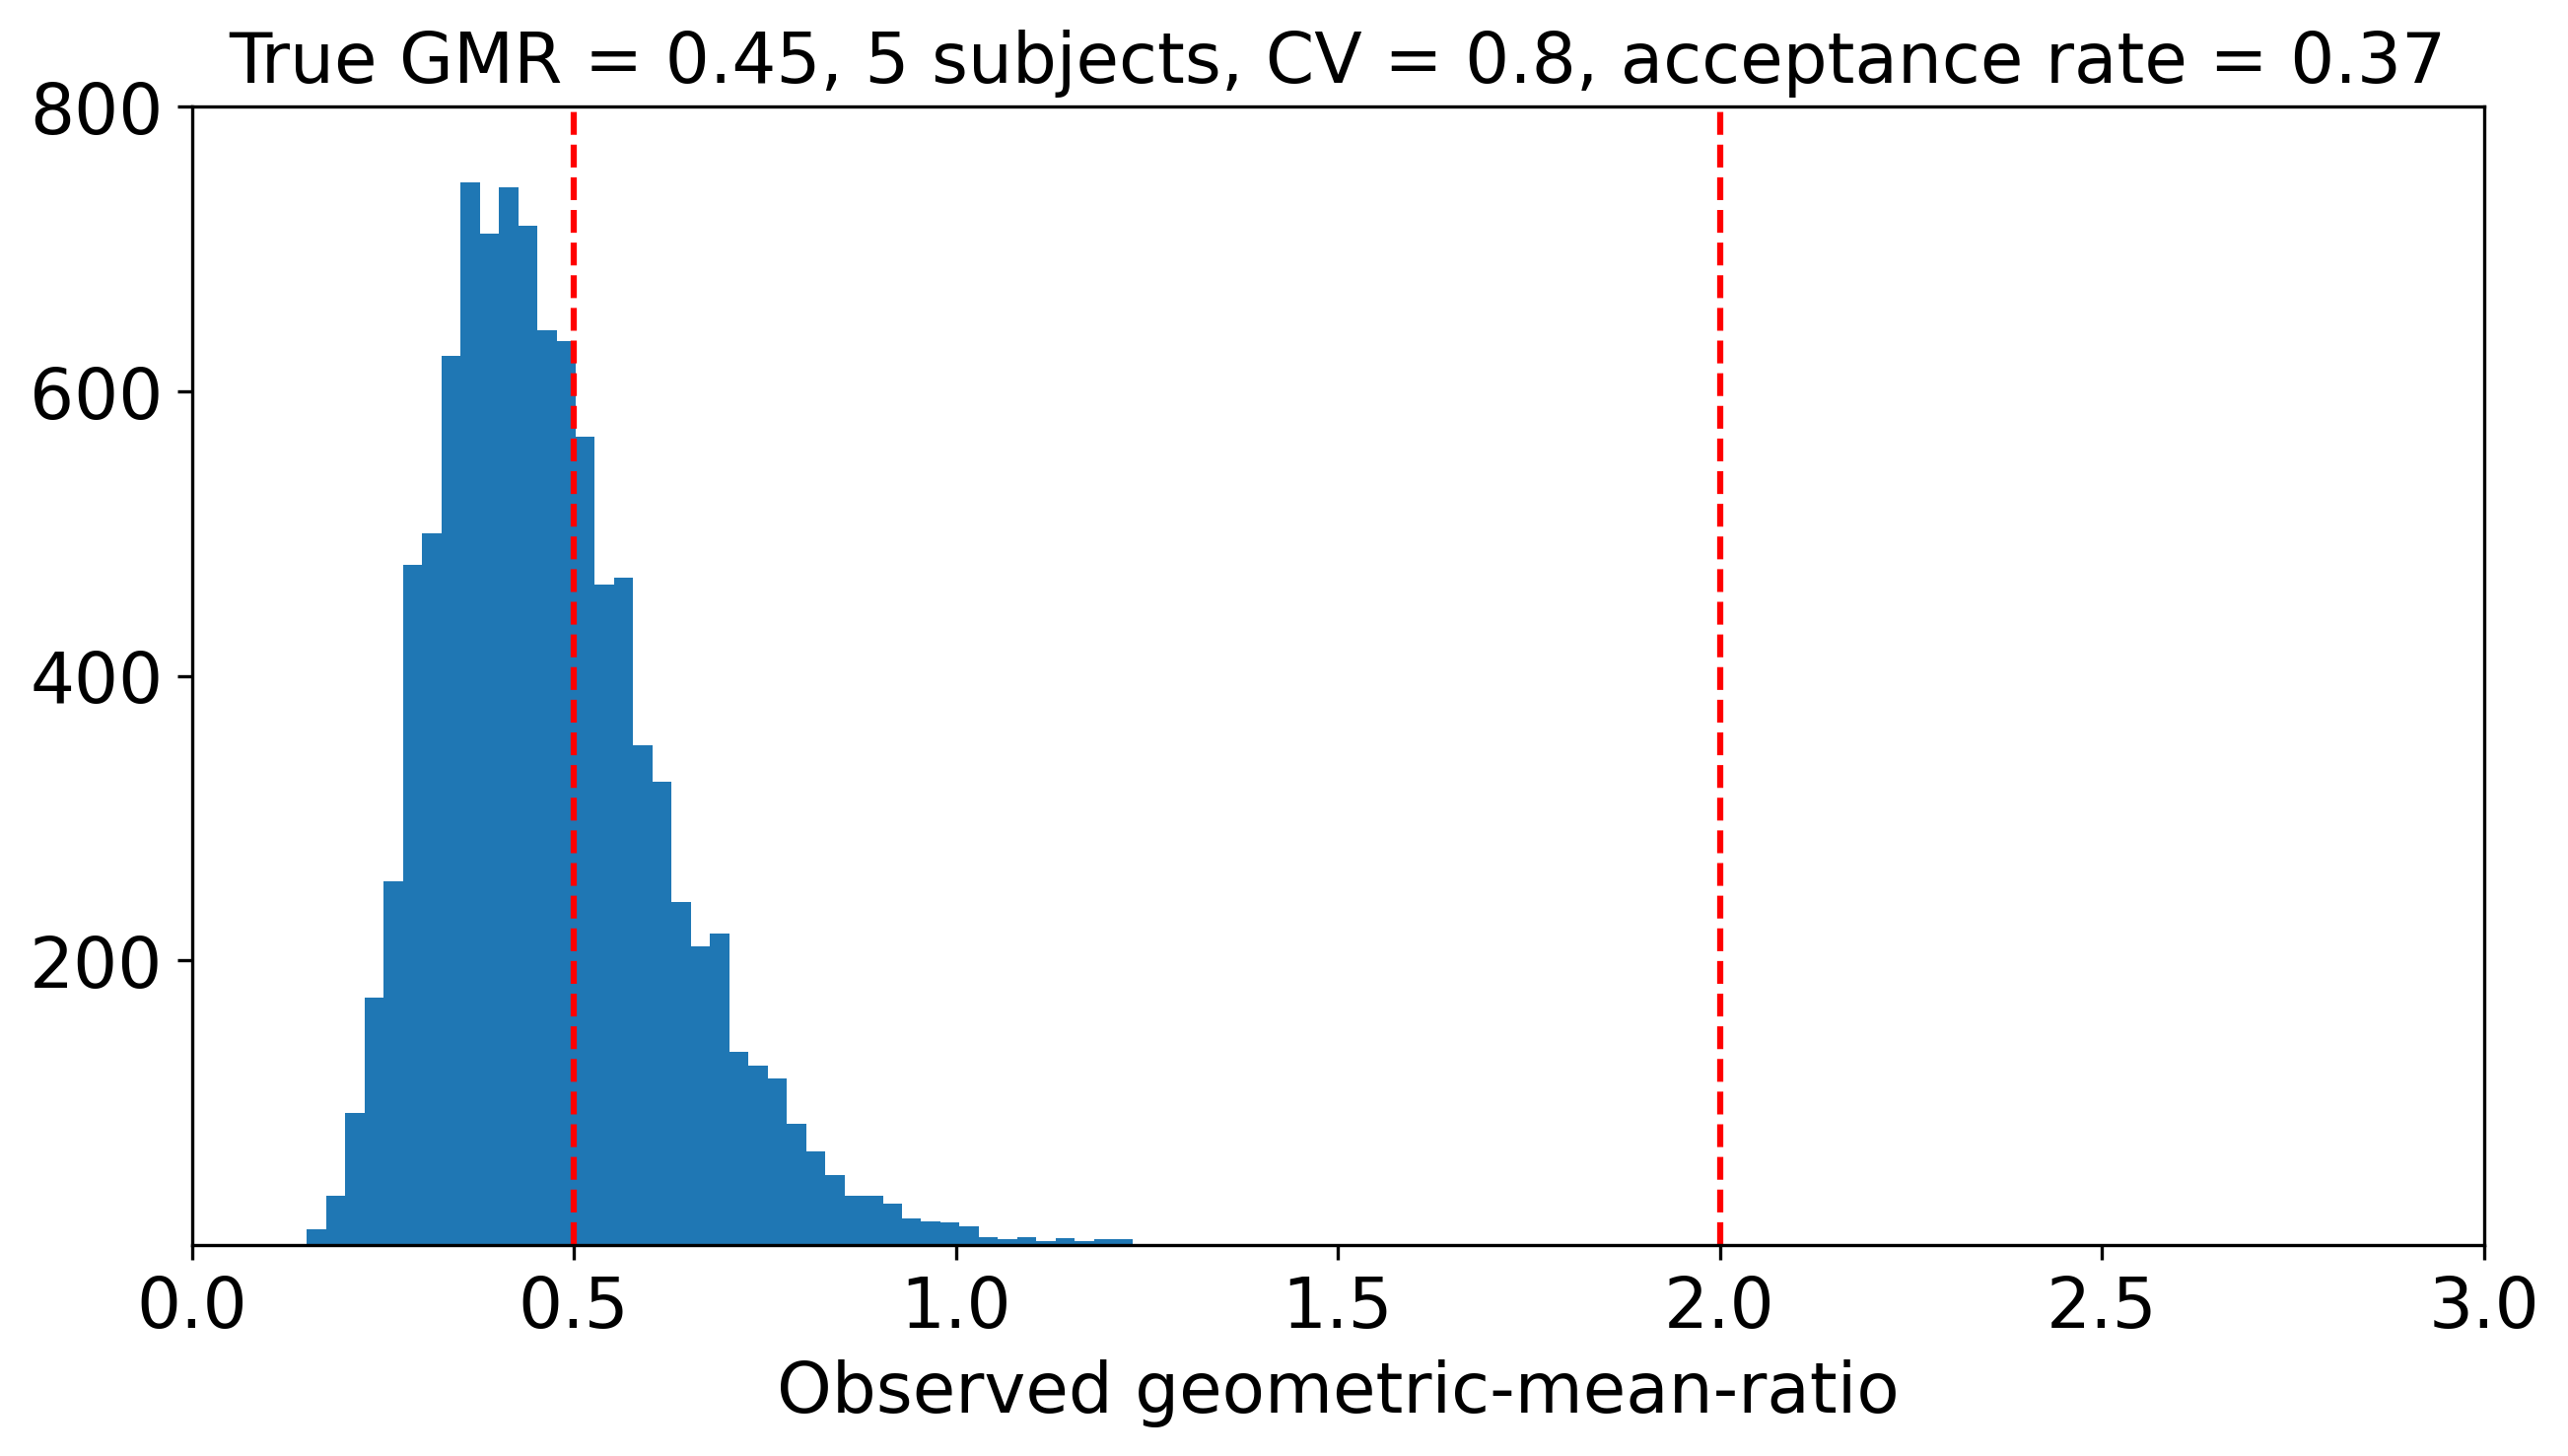

In [7]:
fontsize = 17
plt.figure(dpi=300, figsize=(10, 5))
plt.hist(ratios, bins=np.linspace(0, 5, 200))
plt.xlim((0, 3))
plt.axvline(x=0.5, color='red', linestyle='--')
plt.yticks([200, 400, 600, 800], fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.axvline(x=2, color='red', linestyle='--')
plt.xlabel('Observed geometric-mean-ratio', fontsize=fontsize)
plt.title(f'True GMR = {np.round(actual_ratio, 2)}, {n_subjects} subjects, CV = {CV}, acceptance rate = {np.round(FPR,2)}', fontsize=fontsize)
plt.show()

In [12]:
true_ratios = [0.7, 0.45, 0.4, 0.3]
CVs = [0.8, 0.7, 0.6, 0.5, 0.4]
ns_subjects = [5, 10, 15, 20]
data_frames = {}
for ratio in true_ratios:
    data = []
    for CV in CVs:
        row_data = []
        for n in ns_subjects:
            acceptance_rate = get_acceptance_rate(true_ratio=ratio, CV=CV, n_subjects=n, n_predictions=10000)
            row_data.append(acceptance_rate)
        data.append(row_data)
    df = pd.DataFrame(data, index=CVs, columns=ns_subjects)
    data_frames[ratio] = df

In [15]:
for ratio in true_ratios:
    print(f'True ratio: {ratio}')
    print('CV           number of subjects         ')
    print(f'{np.round(data_frames[ratio],3)}')
    print('-----------------')

True ratio: 0.7
CV           number of subjects         
        5      10     15     20
0.8  0.859  0.934  0.966  0.982
0.7  0.889  0.955  0.979  0.990
0.6  0.911  0.975  0.991  0.996
0.5  0.944  0.985  0.997  0.999
0.4  0.973  0.997  1.000  1.000
-----------------
True ratio: 0.45
CV           number of subjects         
        5      10     15     20
0.8  0.374  0.317  0.287  0.260
0.7  0.359  0.305  0.258  0.229
0.6  0.338  0.272  0.237  0.199
0.5  0.303  0.236  0.197  0.156
0.4  0.268  0.188  0.149  0.112
-----------------
True ratio: 0.4
CV           number of subjects         
        5      10     15     20
0.8  0.235  0.163  0.115  0.082
0.7  0.213  0.130  0.084  0.058
0.6  0.181  0.100  0.059  0.037
0.5  0.149  0.068  0.032  0.019
0.4  0.094  0.032  0.012  0.006
-----------------
True ratio: 0.3
CV           number of subjects         
        5      10     15     20
0.8  0.053  0.008  0.002  0.001
0.7  0.034  0.005  0.001  0.000
0.6  0.021  0.001  0.000  0.000
0.5  0.008  0

## How does our method deal with a bad model?

In the previous example, we saw that the 2-fold method can have a considerable false-positive-rate. The following example illustrates how our method prevents this. If the model is bad, a true GMR of 0.3, and we have a large number of subjects and low variance (20 and 0.5 respectively), our method comes to the same conclusion as the 2-fold method. This is unsurprising since our method is an extension of the 2-fold method.

In [10]:
results = simulate_CI_method(true_ratio=0.3, CV=0.5, n_subjects=20)
print(f'reject: {np.mean(results == 0)}')
print(f'accept: {np.mean(results == 1)}')
print(f'refrain: {np.mean(results == 2)}')

reject: 0.9978
accept: 0.0
refrain: 0.0022


In [11]:
results = simulate_CI_method(true_ratio=0.3, CV=0.8, n_subjects=20)
print(f'reject: {np.mean(results == 0)}')
print(f'accept: {np.mean(results == 1)}')
print(f'refrain: {np.mean(results == 2)}')

reject: 0.9387
accept: 0.0
refrain: 0.0613


In the case, however, where there is not enough evidence to make decision, our method will refrain from doing so. In the below example, we have a model that is close to the acceptable region (a true GMR of 0.45), where the five subjects are simulated from a lognormal distribution with a high CV of 0.8. Our method refrains from making a decision in 86% of simulations.

In [44]:
results = simulate_CI_method(true_ratio=0.45, CV=0.8, n_subjects=5)
print(f'reject: {np.mean(results == 0)}')
print(f'accept: {np.mean(results == 1)}')
print(f'refrain: {np.mean(results == 2)}')

reject: 0.1106
accept: 0.031
refrain: 0.8584


## What happens if the model is good?

We now test a scenario where we have 15 subjects, a good model (the true GMR is 1.2), and a relatively high CV of 0.8. We see that we accept the model in 86% of simulations and refrain from making a decision in 14% of simulations.

In [41]:
results = simulate_CI_method(true_ratio=1.2, CV=0.8, n_subjects=15)
print(f'reject: {np.mean(results == 0)}')
print(f'accept: {np.mean(results == 1)}')
print(f'refrain: {np.mean(results == 2)}')

reject: 0.0
accept: 0.8631
refrain: 0.1369


If we have a lower CV, of 0.5, we accept the model 99% of the time.

In [42]:
results = simulate_CI_method(true_ratio=1.2, CV=0.5, n_subjects=15)
print(f'reject: {np.mean(results == 0)}')
print(f'accept: {np.mean(results == 1)}')
print(f'refrain: {np.mean(results == 2)}')

reject: 0.0
accept: 0.9921
refrain: 0.0079


Similarly, if we have a high CV (0.8), but a larger amount of subjects (30), we also accept the model 99% of the time.

In [80]:
results = simulate_CI_method(true_ratio=1.2, CV=0.8, n_subjects=30)
print(f'reject: {np.mean(results == 0)}')
print(f'accept: {np.mean(results == 1)}')
print(f'refrain: {np.mean(results == 2)}')

reject: 0.0
accept: 0.9874
refrain: 0.0126


Various other scenarios

In [91]:
results = simulate_CI_method(true_ratio=0.7, CV=0.8, n_subjects=5)
print(f'reject: {np.mean(results == 0)}')
print(f'accept: {np.mean(results == 1)}')
print(f'refrain: {np.mean(results == 2)}')

reject: 0.008
accept: 0.2224
refrain: 0.7696


In [92]:
results = simulate_CI_method(true_ratio=0.7, CV=0.8, n_subjects=20)
print(f'reject: {np.mean(results == 0)}')
print(f'accept: {np.mean(results == 1)}')
print(f'refrain: {np.mean(results == 2)}')

reject: 0.0001
accept: 0.6681
refrain: 0.3318


In [93]:
results = simulate_CI_method(true_ratio=0.7, CV=0.5, n_subjects=20)
print(f'reject: {np.mean(results == 0)}')
print(f'accept: {np.mean(results == 1)}')
print(f'refrain: {np.mean(results == 2)}')

reject: 0.0
accept: 0.9312
refrain: 0.0688


In [95]:
results = simulate_CI_method(true_ratio=0.45, CV=0.5, n_subjects=20)
print(f'reject: {np.mean(results == 0)}')
print(f'accept: {np.mean(results == 1)}')
print(f'refrain: {np.mean(results == 2)}')

reject: 0.2608
accept: 0.0053
refrain: 0.7339


## Conclusion

We saw in this notebook that our method really is an extension of the 2-fold method. When we have a large number of subjects or a low variance, both methods will come to the same conclusion. If, however, we do not have a large number of subjects, a high variance, or our model's performance is close to the acceptable boundaries, we see the advantage of our extension. Where the 2-fold approach will always make a choice to accept or reject the model, sometimes with a very non-negligible falls-positive-rate, our method will generally refrain from making a decision, indicating that there is not enough evidence to either accept or reject the model